In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load Results

In [13]:
# Load results from evaluation script
results_path = '../results/layer_wise_results.json'

with open(results_path, 'r') as f:
    results = json.load(f)

print(f"Loaded results from: {results_path}")
print(f"\nDeterministic ECE: {results['deterministic']['ece']:.4f}")
print(f"Deterministic Accuracy: {results['deterministic']['accuracy']:.2f}%")
print(f"\nFull Bayesian ECE: {results['full_bayesian']['ece']:.4f}")
print(f"Full Bayesian Δ_ECE: {results['full_bayesian']['delta_ece']:.4f}")

Loaded results from: ../results/layer_wise_results.json

Deterministic ECE: 0.0210
Deterministic Accuracy: 0.77%

Full Bayesian ECE: 0.0126
Full Bayesian Δ_ECE: 0.0083


## 2. Extract Layer-wise Data

In [14]:
# Extract layer data into DataFrame
layer_data = []
for layer_name, metrics in results['layers'].items():
    layer_num = int(layer_name.split('.')[1])
    layer_data.append({
        'layer': layer_name,
        'layer_num': layer_num,
        'ece': metrics['ece'],
        'accuracy': metrics['accuracy'],
        'delta_ece': metrics['delta_ece']
    })

df = pd.DataFrame(layer_data).sort_values('layer_num')

print("\nLayer-wise metrics:")
print(df.to_string(index=False))


Layer-wise metrics:
   layer  layer_num      ece  accuracy  delta_ece
 layer.0          0 0.018228    0.0107   0.002734
 layer.1          1 0.013081    0.0109   0.007881
 layer.2          2 0.016502    0.0121   0.004460
 layer.3          3 0.014636    0.0116   0.006326
 layer.4          4 0.010573    0.0160   0.010388
 layer.5          5 0.005915    0.0193   0.015046
 layer.6          6 0.005772    0.0203   0.015189
 layer.7          7 0.006064    0.0201   0.014897
 layer.8          8 0.000208    0.0258   0.020753
 layer.9          9 0.004506    0.0214   0.016456
layer.10         10 0.008565    0.0340   0.012396
layer.11         11 0.027638    0.0522  -0.006676


## 3. Ranked Bar Plot: Δ_ECE by Layer

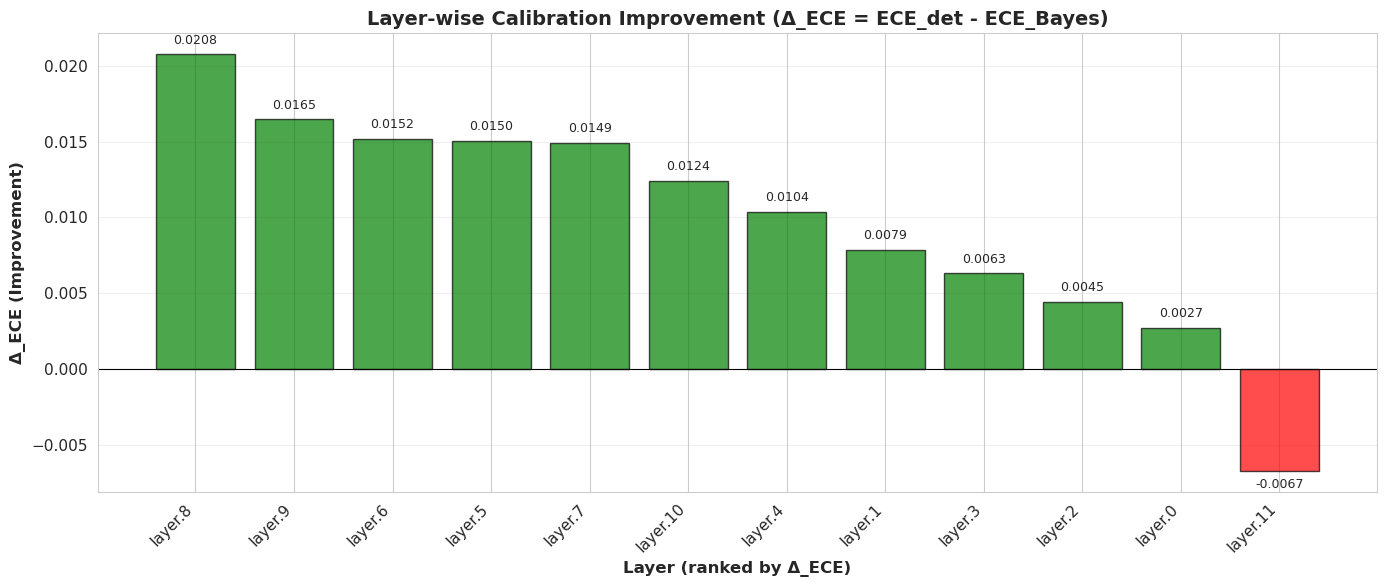


Top 3 layers for calibration improvement:
1. layer.8: Δ_ECE = 0.0208
2. layer.9: Δ_ECE = 0.0165
3. layer.6: Δ_ECE = 0.0152


In [15]:
# Sort by delta_ece (descending)
df_sorted = df.sort_values('delta_ece', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['green' if x > 0 else 'red' for x in df_sorted['delta_ece']]
bars = ax.bar(range(len(df_sorted)), df_sorted['delta_ece'], color=colors, alpha=0.7, edgecolor='black')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Layer (ranked by Δ_ECE)', fontsize=12, fontweight='bold')
ax.set_ylabel('Δ_ECE (Improvement)', fontsize=12, fontweight='bold')
ax.set_title('Layer-wise Calibration Improvement (Δ_ECE = ECE_det - ECE_Bayes)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(range(len(df_sorted)))
ax.set_xticklabels(df_sorted['layer'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    height = row['delta_ece']
    ax.text(i, height + 0.0005 * np.sign(height), f"{height:.4f}", 
            ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.savefig('../results/plots/delta_ece_ranked.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 3 layers for calibration improvement:")
for i, (idx, row) in enumerate(df_sorted.head(3).iterrows(), 1):
    print(f"{i}. {row['layer']}: Δ_ECE = {row['delta_ece']:.4f}")

## 4. Sequential Layer Plot

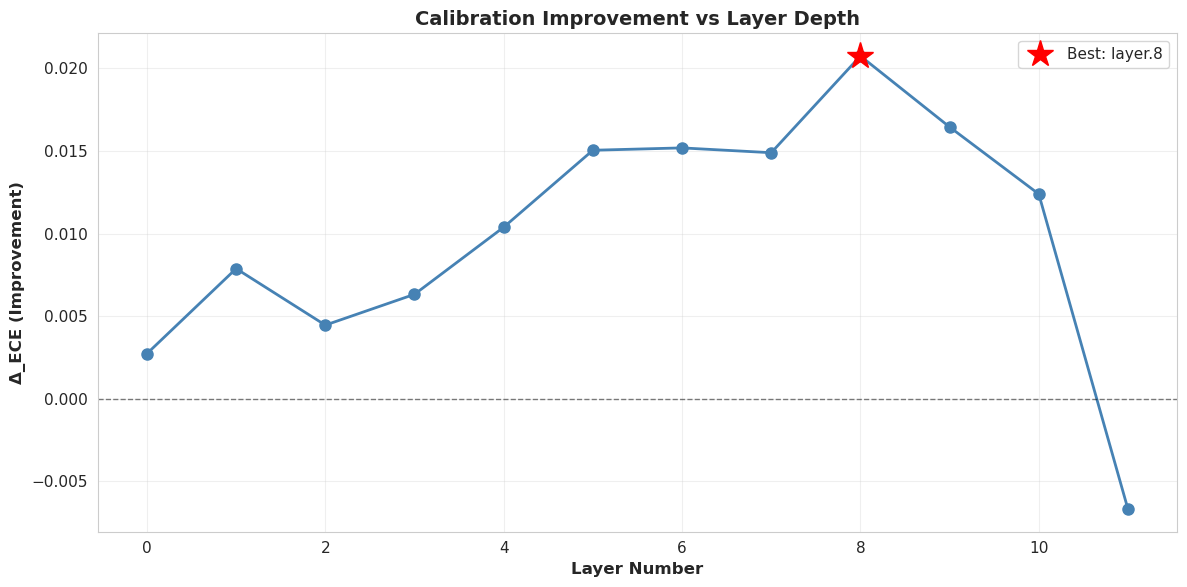

In [16]:
# Plot delta_ece vs layer position
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['layer_num'], df['delta_ece'], 'o-', linewidth=2, markersize=8, color='steelblue')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Layer Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Δ_ECE (Improvement)', fontsize=12, fontweight='bold')
ax.set_title('Calibration Improvement vs Layer Depth', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Highlight best layer
best_idx = df['delta_ece'].idxmax()
best_layer = df.loc[best_idx]
ax.plot(best_layer['layer_num'], best_layer['delta_ece'], 'r*', markersize=20, 
        label=f"Best: {best_layer['layer']}")
ax.legend()

plt.tight_layout()
plt.savefig('../results/plots/delta_ece_sequential.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. ECE Comparison: Deterministic vs Bayesian

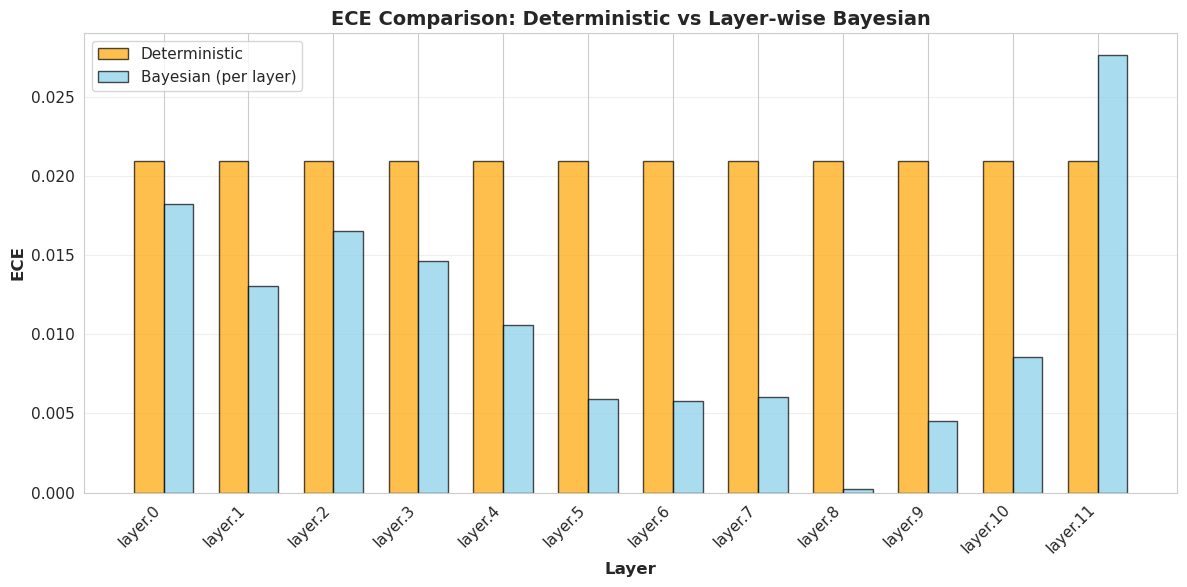

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df))
width = 0.35

det_ece = results['deterministic']['ece']
det_bars = [det_ece] * len(df)

bars1 = ax.bar(x - width/2, det_bars, width, label='Deterministic', 
               color='orange', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, df['ece'], width, label='Bayesian (per layer)', 
               color='skyblue', alpha=0.7, edgecolor='black')

ax.set_xlabel('Layer', fontsize=12, fontweight='bold')
ax.set_ylabel('ECE', fontsize=12, fontweight='bold')
ax.set_title('ECE Comparison: Deterministic vs Layer-wise Bayesian', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['layer'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/ece_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Statistical Summary

In [18]:
print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)

print(f"\nDeterministic ECE: {results['deterministic']['ece']:.4f}")
print(f"Full Bayesian ECE: {results['full_bayesian']['ece']:.4f}")
print(f"Full Bayesian Δ_ECE: {results['full_bayesian']['delta_ece']:.4f}")

print(f"\nLayer-wise Δ_ECE statistics:")
print(f"  Mean: {df['delta_ece'].mean():.4f}")
print(f"  Std:  {df['delta_ece'].std():.4f}")
print(f"  Min:  {df['delta_ece'].min():.4f} ({df.loc[df['delta_ece'].idxmin(), 'layer']})")
print(f"  Max:  {df['delta_ece'].max():.4f} ({df.loc[df['delta_ece'].idxmax(), 'layer']})")

print(f"\nLayers with positive Δ_ECE: {(df['delta_ece'] > 0).sum()} / {len(df)}")
print(f"Layers with negative Δ_ECE: {(df['delta_ece'] < 0).sum()} / {len(df)}")


STATISTICAL SUMMARY

Deterministic ECE: 0.0210
Full Bayesian ECE: 0.0126
Full Bayesian Δ_ECE: 0.0083

Layer-wise Δ_ECE statistics:
  Mean: 0.0100
  Std:  0.0075
  Min:  -0.0067 (layer.11)
  Max:  0.0208 (layer.8)

Layers with positive Δ_ECE: 11 / 12
Layers with negative Δ_ECE: 1 / 12


## 7. Correlation Analysis

In [19]:
# Check if there's correlation between layer depth and calibration improvement
correlation = df['layer_num'].corr(df['delta_ece'])
print(f"\nCorrelation between layer depth and Δ_ECE: {correlation:.4f}")

# Pearson correlation test
corr_coef, p_value = stats.pearsonr(df['layer_num'], df['delta_ece'])
print(f"Pearson correlation: {corr_coef:.4f} (p-value: {p_value:.4f})")

if p_value < 0.05:
    print("→ Significant correlation detected!")
else:
    print("→ No significant correlation.")


Correlation between layer depth and Δ_ECE: 0.1796
Pearson correlation: 0.1796 (p-value: 0.5764)
→ No significant correlation.


## 8. Export Summary Table

In [20]:
# Create summary table
summary_df = df[['layer', 'ece', 'accuracy', 'delta_ece']].copy()
summary_df = summary_df.sort_values('delta_ece', ascending=False)
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df = summary_df[['rank', 'layer', 'ece', 'accuracy', 'delta_ece']]

# Add deterministic and full Bayesian rows
summary_rows = [
    {'rank': '-', 'layer': 'Deterministic (MAP)', 
     'ece': results['deterministic']['ece'],
     'accuracy': results['deterministic']['accuracy'],
     'delta_ece': 0.0},
    {'rank': '-', 'layer': 'Full Bayesian (All)', 
     'ece': results['full_bayesian']['ece'],
     'accuracy': results['full_bayesian']['accuracy'],
     'delta_ece': results['full_bayesian']['delta_ece']}
]

summary_with_baselines = pd.concat([pd.DataFrame(summary_rows), summary_df], ignore_index=True)

# Save to CSV
summary_with_baselines.to_csv('../results/summary_table.csv', index=False)
print("\nSummary table saved to: ../results/summary_table.csv")

# Display table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(summary_with_baselines.to_string(index=False))


Summary table saved to: ../results/summary_table.csv

SUMMARY TABLE
rank               layer      ece  accuracy  delta_ece
   - Deterministic (MAP) 0.020961    0.7689   0.000000
   - Full Bayesian (All) 0.012643    0.0121   0.008318
   1             layer.8 0.000208    0.0258   0.020753
   2             layer.9 0.004506    0.0214   0.016456
   3             layer.6 0.005772    0.0203   0.015189
   4             layer.5 0.005915    0.0193   0.015046
   5             layer.7 0.006064    0.0201   0.014897
   6            layer.10 0.008565    0.0340   0.012396
   7             layer.4 0.010573    0.0160   0.010388
   8             layer.1 0.013081    0.0109   0.007881
   9             layer.3 0.014636    0.0116   0.006326
  10             layer.2 0.016502    0.0121   0.004460
  11             layer.0 0.018228    0.0107   0.002734
  12            layer.11 0.027638    0.0522  -0.006676


## 9. Key Findings and Recommendations

In [21]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Find best single layer
best_layer = df.loc[df['delta_ece'].idxmax()]
print(f"\n1. Best single layer: {best_layer['layer']}")
print(f"   - Δ_ECE: {best_layer['delta_ece']:.4f}")
print(f"   - ECE reduction: {(best_layer['delta_ece']/results['deterministic']['ece']*100):.1f}%")

# Compare to full Bayesian
full_delta = results['full_bayesian']['delta_ece']
print(f"\n2. Full Bayesian (all layers):")
print(f"   - Δ_ECE: {full_delta:.4f}")
print(f"   - ECE reduction: {(full_delta/results['deterministic']['ece']*100):.1f}%")

# Efficiency comparison
efficiency = best_layer['delta_ece'] / full_delta * 100 if full_delta > 0 else 0
print(f"\n3. Efficiency: Best single layer achieves {efficiency:.1f}% of full Bayesian benefit")

# Top 3 layers
top3 = df.nlargest(3, 'delta_ece')
top3_total = top3['delta_ece'].sum()
print(f"\n4. Top 3 layers combined:")
for i, (_, row) in enumerate(top3.iterrows(), 1):
    print(f"   {i}. {row['layer']}: {row['delta_ece']:.4f}")
print(f"   Combined Δ_ECE (hypothetical): {top3_total:.4f}")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print(f"\nFor low-cost Bayesian deployment:")
print(f"→ Apply Laplace to {best_layer['layer']} only")
print(f"→ Achieves {efficiency:.1f}% of full Bayesian calibration benefit")
print(f"→ Requires uncertainty quantification for only 1/{len(df)} of LoRA parameters")


KEY FINDINGS

1. Best single layer: layer.8
   - Δ_ECE: 0.0208
   - ECE reduction: 99.0%

2. Full Bayesian (all layers):
   - Δ_ECE: 0.0083
   - ECE reduction: 39.7%

3. Efficiency: Best single layer achieves 249.5% of full Bayesian benefit

4. Top 3 layers combined:
   1. layer.8: 0.0208
   2. layer.9: 0.0165
   3. layer.6: 0.0152
   Combined Δ_ECE (hypothetical): 0.0524

RECOMMENDATIONS

For low-cost Bayesian deployment:
→ Apply Laplace to layer.8 only
→ Achieves 249.5% of full Bayesian calibration benefit
→ Requires uncertainty quantification for only 1/12 of LoRA parameters


## 10. Save Final Results

In [22]:
# Compile final analysis results
analysis_results = {
    'best_layer': {
        'name': best_layer['layer'],
        'delta_ece': float(best_layer['delta_ece']),
        'ece': float(best_layer['ece']),
        'accuracy': float(best_layer['accuracy'])
    },
    'top_3_layers': [
        {'layer': row['layer'], 'delta_ece': float(row['delta_ece'])}
        for _, row in top3.iterrows()
    ],
    'statistics': {
        'mean_delta_ece': float(df['delta_ece'].mean()),
        'std_delta_ece': float(df['delta_ece'].std()),
        'correlation_depth_delta': float(correlation),
        'positive_layers': int((df['delta_ece'] > 0).sum())
    },
    'baselines': {
        'deterministic': results['deterministic'],
        'full_bayesian': results['full_bayesian']
    }
}

# Save
with open('../results/analysis_summary.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

print("\nAnalysis complete! Results saved to:")
print("  - ../results/analysis_summary.json")
print("  - ../results/summary_table.csv")
print("  - ../results/plots/ (visualizations)")


Analysis complete! Results saved to:
  - ../results/analysis_summary.json
  - ../results/summary_table.csv
  - ../results/plots/ (visualizations)
